In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import sklearn
from sklearn.metrics import mean_squared_error

from itertools import product

import pickle


In [2]:
#Read all csv files to dataframe
df_items = pd.read_csv("items.csv")
df_sales_train = pd.read_csv("sales_train.csv")
df_item_categories = pd.read_csv("item_categories.csv")
df_test = pd.read_csv("test.csv")
df_shops = pd.read_csv("shops.csv")
df_sample_submission = pd.read_csv("sample_submission.csv")

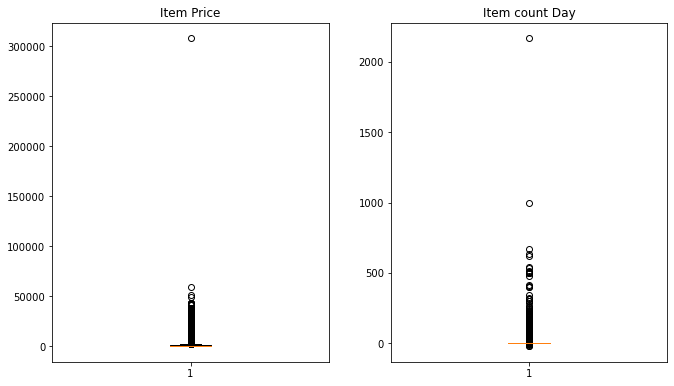

In [3]:
#plot the item_price and item_cnt_day so we can see the irregularities
plt.figure(figsize=(10,6))
plt.subplot(121)
plt.boxplot(df_sales_train['item_price'])
plt.title('Item Price')
plt.subplot(122)
plt.boxplot(df_sales_train['item_cnt_day'])
plt.title('Item count Day')
plt.tight_layout(pad=3)
plt.show()

In [4]:
irregular = df_sales_train[df_sales_train['item_price']> 50000]
print(irregular)

               date  date_block_num  shop_id  item_id  item_price  \
885138   17.09.2013               8       12    11365     59200.0   
1163158  13.12.2013              11       12     6066    307980.0   
1488135  20.03.2014              14       25    13199     50999.0   

         item_cnt_day  
885138            1.0  
1163158           1.0  
1488135           1.0  


In [5]:
median = df_sales_train[(df_sales_train.item_id==11365)]['item_price'].median()
print(median)

1203.75


In [6]:
median = df_sales_train[(df_sales_train.item_id==6066)]['item_price'].median()
print(median)

307980.0


In [7]:
median = df_sales_train[(df_sales_train.item_id==13199)]['item_price'].median()
print(median)

50999.0


In [8]:
#clean irregular data
df_sales_train = df_sales_train[(df_sales_train['item_price']<50000) & (df_sales_train['item_cnt_day']<1000)]

In [9]:
#Negative values
df_sales_train = df_sales_train[df_sales_train['item_price'] > 0]

In [10]:
#read the shop names
df_shops['shop_name'].groupby(df_shops.shop_id).value_counts()

shop_id  shop_name                                      
0        !Якутск Орджоникидзе, 56 фран                      1
1        !Якутск ТЦ "Центральный" фран                      1
2        Адыгея ТЦ "Мега"                                   1
3        Балашиха ТРК "Октябрь-Киномир"                     1
4        Волжский ТЦ "Волга Молл"                           1
5        Вологда ТРЦ "Мармелад"                             1
6        Воронеж (Плехановская, 13)                         1
7        Воронеж ТРЦ "Максимир"                             1
8        Воронеж ТРЦ Сити-Парк "Град"                       1
9        Выездная Торговля                                  1
10       Жуковский ул. Чкалова 39м?                         1
11       Жуковский ул. Чкалова 39м²                         1
12       Интернет-магазин ЧС                                1
13       Казань ТЦ "Бехетле"                                1
14       Казань ТЦ "ПаркХаус" II                            1
15       Калу

In [11]:
#We found repetitive names, so we can combine them
df_sales_train.loc[df_sales_train.shop_id == 0,'shop_id']=57
df_test.loc[df_test.shop_id == 0,'shop_id']=57
df_sales_train.loc[df_sales_train.shop_id == 1,'shop_id']=58
df_test.loc[df_test.shop_id == 1,'shop_id']=58
df_sales_train.loc[df_sales_train.shop_id == 10,'shop_id']=11
df_test.loc[df_test.shop_id == 10,'shop_id']=11

In [12]:
#add the item_ID we want to predict
df_sales_train = pd.merge(df_sales_train,df_items,how='left', on=['item_id'])
df_sales_train.fillna(0,inplace=True)

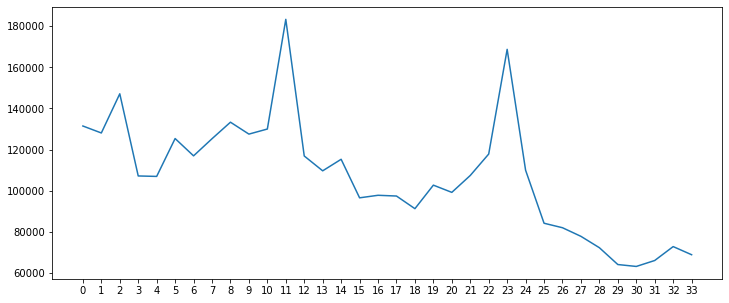

In [13]:
month_sale = df_sales_train.groupby(['date_block_num'], as_index = False)["item_cnt_day"].sum().to_numpy()
plt.figure(figsize=(12,5))
plt.plot(month_sale[:,0],month_sale[:,1])
plt.xticks(np.arange(0, 34, 1.0))
plt.show()

In [14]:
b = (month_sale[33,1]-month_sale[0,1])/(month_sale[33,0]-month_sale[0,0])
month_sale_trend = np.zeros((34,2))
month_sale_average = np.zeros((34,2))
for x in range(34):
    y = x*b+month_sale[0,1]
    month_sale_trend[x,0] = x
    month_sale_trend[x,1] = y
    month_sale_average[x,0] = x
    month_sale_average[x,1] = month_sale[x,1] - y
del b,x,y

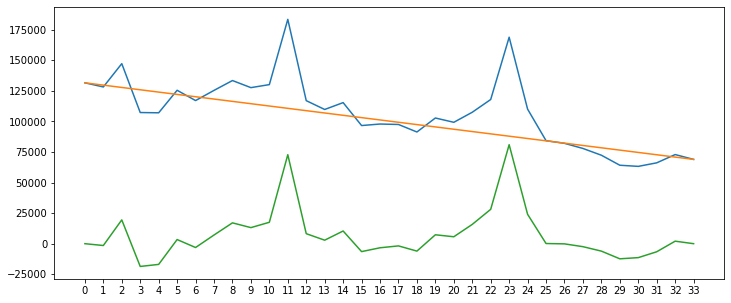

In [15]:
plt.figure(figsize=(12,5))
plt.plot(month_sale[:,0],month_sale[:,1])
plt.plot(month_sale_trend[:,0],month_sale_trend[:,1])
plt.plot(month_sale_average[:,0],month_sale_average[:,1])
plt.xticks(np.arange(0, 34, 1.0))
plt.show()

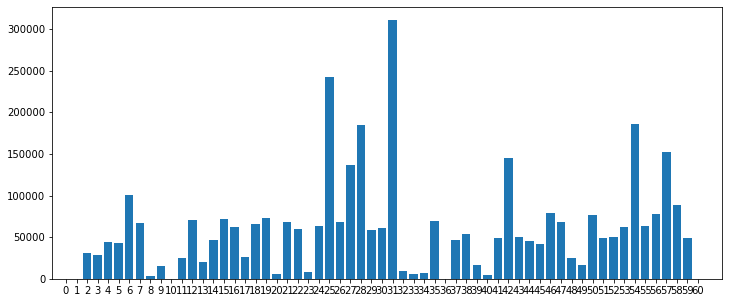

In [16]:
df_new = df_sales_train.groupby(['shop_id'], as_index = False)["item_cnt_day"].sum().to_numpy()
plt.figure(figsize=(12,5))
plt.bar(df_new[:,0],df_new[:,1])
plt.xticks(np.arange(0, 61, 1))
plt.show()

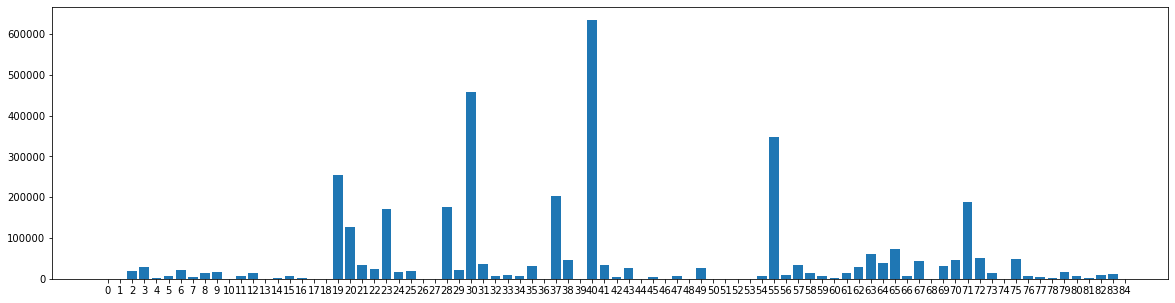

In [17]:
df_new = df_sales_train.groupby(['item_category_id'], as_index = False)["item_cnt_day"].sum().to_numpy()
plt.figure(figsize=(20,5))
plt.bar(df_new[:,0],df_new[:,1])
plt.xticks(np.arange(0, 85, 1))
plt.show()

In [18]:
#add the test ID we want to predict
df_test['date_block_num'] = 34
df_sales_train = pd.concat([df_sales_train,df_test],ignore_index=True,
                        sort = False,keys = ['date_block_num','shop_id','item_id'])
df_sales_train.fillna(0,inplace=True)
df_sales_train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,ID
3150038,0,34,45,18454,0.0,0.0,0,0.0,214195.0
3150039,0,34,45,16188,0.0,0.0,0,0.0,214196.0
3150040,0,34,45,15757,0.0,0.0,0,0.0,214197.0
3150041,0,34,45,19648,0.0,0.0,0,0.0,214198.0
3150042,0,34,45,969,0.0,0.0,0,0.0,214199.0


In [19]:
# Create "grid" with columns
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in df_sales_train['date_block_num'].unique():
    cur_shops = df_sales_train.loc[df_sales_train['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = df_sales_train.loc[df_sales_train['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int16'))

# Turn the grid into a dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [20]:
#Create a column with month count
df_new = df_sales_train.groupby(index_cols,as_index=False)["item_cnt_day"].sum()
df_new = df_new.rename(columns = {"item_cnt_day": "target"})
all_data = pd.merge(grid, df_new, how='left', on=index_cols).fillna(0)
all_data.head()

,shop_id,item_id,date_block_num,target
0,59,22154,0,1.0
1,59,2552,0,0.0
2,59,2554,0,0.0
3,59,2555,0,0.0
4,59,2564,0,0.0


In [21]:
#Create a column with mean encoded shop_id
df_new = df_sales_train.groupby(['shop_id', 'date_block_num'],as_index=False)["item_cnt_day"].sum()
df_new = df_new.rename(columns = {"item_cnt_day": "target_shop"})
all_data = pd.merge(all_data, df_new, how='left', on=['shop_id', 'date_block_num']).fillna(0)
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop
0,59,22154,0,1.0,2017.0
1,59,2552,0,0.0,2017.0
2,59,2554,0,0.0,2017.0
3,59,2555,0,0.0,2017.0
4,59,2564,0,0.0,2017.0


In [22]:
#Create a column with mean encoded item_id
df_new = df_sales_train.groupby(['item_id', 'date_block_num'],as_index=False)["item_cnt_day"].sum()
df_new = df_new.rename(columns = {"item_cnt_day": "target_item"})
all_data = pd.merge(all_data, df_new, how='left', on=['item_id', 'date_block_num']).fillna(0)
all_data.head()

,shop_id,item_id,date_block_num,target,target_shop,target_item
0,59,22154,0,1.0,2017.0,18.0
1,59,2552,0,0.0,2017.0,0.0
2,59,2554,0,0.0,2017.0,1.0
3,59,2555,0,0.0,2017.0,2.0
4,59,2564,0,0.0,2017.0,5.0


In [23]:
del grid, df_new

In [24]:
#Names of new columns
cols_to_rename = list(all_data.columns.difference(index_cols)) 
cols_to_rename

['target', 'target_item', 'target_shop']

In [25]:
shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in shift_range:

    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift


In [26]:
all_data.tail().transpose()

,11127951,11127952,11127953,11127954,11127955
shop_id,45.0,45.0,45.0,45.0,45.0
item_id,18454.0,16188.0,15757.0,19648.0,969.0
date_block_num,34.0,34.0,34.0,34.0,34.0
target,0.0,0.0,0.0,0.0,0.0
target_shop,0.0,0.0,0.0,0.0,0.0
target_item,0.0,0.0,0.0,0.0,0.0
target_lag_1,1.0,0.0,0.0,0.0,0.0
target_item_lag_1,2.0,1.0,5.0,2.0,3.0
target_shop_lag_1,702.0,702.0,702.0,702.0,702.0
target_lag_2,0.0,0.0,0.0,0.0,0.0


In [27]:
# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

In [28]:
# We will drop these at fitting stage
to_drop_cols = ['target', 'target_shop', 'target_item', 'date_block_num']

# Category for each item
item_category_mapping = df_items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data.to_pickle("data.pkl")
del all_data

In [29]:
#Train/Split
#For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [30]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
all_data = pd.read_pickle("data.pkl")
dates = all_data['date_block_num']

In [31]:
dates_train = dates[dates < 33]
dates_target  = dates[dates == 33]

X_train = all_data.loc[dates <  33].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == 33].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  33, 'target'].values
y_test =  all_data.loc[dates == 33, 'target'].values


In [32]:
#we will run linear regression on numeric columns and get predictions for the last month.

lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)
mse = mean_squared_error(pred_lr, y_test, squared=False)
print(mse)

2.52270713567186


In [33]:
#lgb model
lgb_params = {

            'feature_fraction': 0.75,
            'metric': 'rmse',
           'nthread':1, 
           'min_data_in_leaf': 2**7, 
           'bagging_fraction': 0.75, 
           'learning_rate': 0.03, 
           'objective': 'mse', 
           'bagging_seed': 2**7, 
           'num_leaves': 2**7,
           'bagging_freq':1,
           'verbose':0 
          }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)
mse = mean_squared_error(pred_lgb, y_test, squared=False)
print(mse)

2.507335809822127


In [34]:
X_test_level2 = np.c_[pred_lr, pred_lgb]
X_test_level2

array([[0.12629944, 0.05817722],
       [0.79221693, 0.82198447],
       [0.9967755 , 0.5318341 ],
       ...,
       [0.10347263, 0.21777319],
       [0.12692807, 0.06040953],
       [0.0498505 , 0.0438579 ]])

In [35]:
# get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([26, 27, 28, 29, 30, 31, 32])]

In [36]:
#And here we create 2nd level feeature matrix, init it with zeros first
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

In [ ]:
#training with metafeatures
xposition = 0 
# Now fill `X_train_level2` with metafeatures
for cur_block_num in [26, 27, 28, 29, 30, 31, 32]:
    
    X_train = all_data.loc[dates <  cur_block_num].drop(to_drop_cols, axis=1)
    X_test =  all_data.loc[dates == cur_block_num].drop(to_drop_cols, axis=1)

    y_train = all_data.loc[dates <  cur_block_num, 'target'].values

    lr.fit(X_train.values, y_train)
    pred_lr = lr.predict(X_test.values)
    
    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_test)
    
    dates_train_level2 = np.c_[pred_lr, pred_lgb] 
    
    X_train_level2[xposition:(xposition + X_test.shape[0])]=dates_train_level2
    xposition = xposition + X_test.shape[0] 

In [ ]:
#simple convex mix
alphas_to_try = np.linspace(0, 1, 1001)

error = 1000
for a in alphas_to_try:
    mix = a * X_train_level2[:,0] + (1 - a) * X_train_level2[:,1]
    mse = sklearn.metrics.mean_squared_error(mix, y_train_level2)
    if mse < error:
        best_alpha = a
        r2_train_simple_mix = sklearn.metrics.r2_score(y_train_level2, mix)
        error = mse

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

In [ ]:
test_preds = best_alpha * X_test_level2[:,0] + (1 - best_alpha) * X_test_level2[:,1]
mse = mean_squared_error(test_preds, y_test, squared=False)
print(mse)

In [ ]:
#stacking
lr.fit(X_train_level2, y_train_level2)

In [ ]:
test_preds = lr.predict(X_test_level2)
mse = mean_squared_error(test_preds, y_test, squared=False)
print(mse)